In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib, os

data_path = '/Users/onurcan/Documents/GDG_HATAY/Dataset.xlsx'
df = pd.read_excel(data_path)
df_clean = df.dropna()
feature_cols = ['Kesme Gücü', 'İlerleme Hızı', 'RPM']
X = df_clean[feature_cols]
y = df_clean['AşınmaOranı']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Karşılaştırma

In [2]:
models = {
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42)
}

results = []
for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    pred = mdl.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    rmse = mean_squared_error(y_test, pred) ** 0.5
    r2 = r2_score(y_test, pred)
    cv_mae = -cross_val_score(mdl, X, y, cv=5, scoring='neg_mean_absolute_error')
    results.append({
        'model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2,
        'CV_MAE_mean': cv_mae.mean(), 'CV_MAE_std': cv_mae.std()
    })
results_df = pd.DataFrame(results).sort_values(by='MAE')
display(results_df)
best = results_df.iloc[0]
best_name = best['model']
best_model = models[best_name]
print('En iyi model:', best_name)
if hasattr(best_model, 'feature_importances_'):
    fi = best_model.feature_importances_
    for col, imp in sorted(zip(feature_cols, fi), key=lambda x: x[1], reverse=True):
        print(f'Özellik Önemi - {col}: {imp:.3f}')

,model,MAE,RMSE,R2,CV_MAE_mean,CV_MAE_std
1,GradientBoosting,1.049843,1.430493,0.605119,1.286327,0.253927
2,HistGradientBoosting,1.149928,1.556078,0.532742,1.321630,0.225174
0,RandomForest,1.155644,1.572291,0.522954,1.325800,0.222474


En iyi model: GradientBoosting
Özellik Önemi - Kesme Gücü: 0.398
Özellik Önemi - İlerleme Hızı: 0.367
Özellik Önemi - RPM: 0.234


## Hata Analizi (En İyi Model)

count    368.000000
mean      -0.053270
std        1.431447
min       -4.294801
25%       -0.866393
50%       -0.079272
75%        0.680005
max        4.928909
Name: AşınmaOranı, dtype: float64


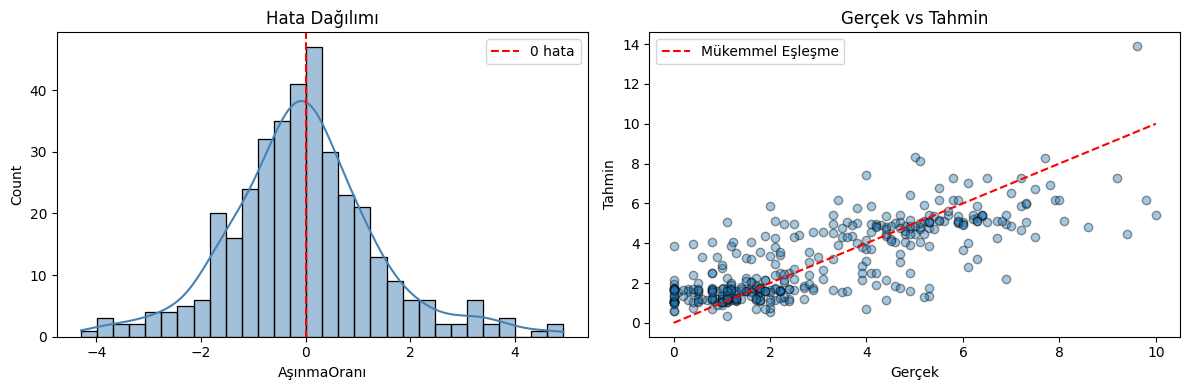

In [3]:
best_pred = best_model.predict(X_test)
residuals = y_test - best_pred
print(residuals.describe())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(residuals, bins=30, kde=True, ax=axes[0], color='steelblue')
axes[0].axvline(0, color='red', linestyle='--', label='0 hata')
axes[0].set_title('Hata Dağılımı')
axes[0].legend()

axes[1].scatter(y_test, best_pred, alpha=0.4, edgecolor='k')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Mükemmel Eşleşme')
axes[1].set_xlabel('Gerçek')
axes[1].set_ylabel('Tahmin')
axes[1].set_title('Gerçek vs Tahmin')
axes[1].legend()
plt.tight_layout()
plt.show()

## Model Kaydetme (Joblib)

In [9]:
os.makedirs('models', exist_ok=True)
model_path = f"models/wear_{best_name.lower()}_model.joblib"
joblib.dump({'model': best_model, 'features': feature_cols}, model_path)
print('Kaydedildi:', model_path)

loaded = joblib.load(model_path)
sample = X_test.head(3)
pred_loaded = loaded['model'].predict(sample)
for i, (t, p) in enumerate(zip(y_test.head(3), pred_loaded), 1):
    print(f"Örnek {i}: Gerçek={t:.2f}, Tahmin={p:.2f}")

Kaydedildi: models/wear_gradientboosting_tuned_model.joblib
Örnek 1: Gerçek=4.90, Tahmin=2.84
Örnek 2: Gerçek=4.40, Tahmin=4.60
Örnek 3: Gerçek=3.30, Tahmin=3.21


## Hiperparametre Araması (Opsiyonel)
RandomizedSearchCV ile GradientBoosting'i iyileştirmek için çalıştırılabilir.

In [13]:
# İsteğe bağlı: çalıştırmak süre alabilir.
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
param_dist = {
    'n_estimators': randint(100, 400),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'max_depth': randint(2, 6),
    'min_samples_leaf': randint(1, 6)
}
gb = GradientBoostingRegressor(random_state=42)
search = RandomizedSearchCV(
    gb, param_dist, n_iter=20, cv=5, scoring='neg_mean_absolute_error',
    n_jobs=-1, random_state=42, verbose=0
)
search.fit(X, y)
best_gb = search.best_estimator_
print('Best params:', search.best_params_)
print('Best CV MAE:', -search.best_score_)

Best params: {'learning_rate': np.float64(0.0412037280884873), 'max_depth': 4, 'min_samples_leaf': 3, 'n_estimators': 187, 'subsample': np.float64(0.8001125833417065)}
Best CV MAE: 1.2921140560705093


## Hiperparametre Sonrası Model Güncellemesi
Hiperparametre araması çalıştırıldıysa, bulunan `best_gb` modeli önceki en iyi modelle karşılaştırıp daha iyiyse onu varsayılan olarak kullanır ve kaydeder.

In [14]:
# Varsayılan olarak önceki en iyi modeli kullanıyoruz; eğer best_gb varsa ve daha iyi ise güncelle.
try:
    # Eğer hiperparametre araması çalıştıysa best_gb ve search objeleri mevcut olacak
    tuned_pred = best_gb.predict(X_test)
    tuned_mae = mean_absolute_error(y_test, tuned_pred)
    tuned_rmse = mean_squared_error(y_test, tuned_pred) ** 0.5
    tuned_r2 = r2_score(y_test, tuned_pred)

    print(f"Tuned GB Test -> MAE: {tuned_mae:.3f}, RMSE: {tuned_rmse:.3f}, R²: {tuned_r2:.3f}")

    # Mevcut best_model performansı
    base_pred = best_model.predict(X_test)
    base_mae = mean_absolute_error(y_test, base_pred)

    if tuned_mae < base_mae:
        best_model = best_gb
        best_name = 'GradientBoosting_Tuned'
        print("\nTuned model daha iyi; best_model güncellendi ve kaydedilecek model bu olacak.")
    else:
        print("\nTuned model daha iyi değil; önceki en iyi model korunacak.")
except NameError:
    print("Hiperparametre araması (best_gb) çalıştırılmadı; önceki en iyi model kullanılacak.")

Tuned GB Test -> MAE: 0.913, RMSE: 1.216, R²: 0.715

Tuned model daha iyi değil; önceki en iyi model korunacak.
